In [27]:
import pandas as pd
import pyodbc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, r2_score, classification_report

# 🔌 Connexion à la base SQL Server
conn = pyodbc.connect('DRIVER={SQL Server};SERVER=KARIM;DATABASE=DW;Trusted_Connection=yes;')

# 📥 Requêtes SQL
query_category = "SELECT Category_PK, Category FROM [DW].[dbo].[Dim_Category]"
query_product = "SELECT Product_PK, ProductName, Category_FK FROM [DW].[dbo].[Dim_Product]"
query_sales = """
SELECT TOP (10000) Product_PK, Prix_Unitaire_TND_1
FROM [DW].[dbo].[Fact_Sales]
WHERE Prix_Unitaire_TND_1 IS NOT NULL
"""

# 📊 Chargement des données
df_cat = pd.read_sql(query_category, conn)
df_prod = pd.read_sql(query_product, conn)
df_sales = pd.read_sql(query_sales, conn)

conn.close()

# 🔗 Fusion des données
df = df_sales.merge(df_prod, left_on='Product_PK', right_on='Product_PK')
df = df.merge(df_cat, left_on='Category_FK', right_on='Category_PK')

# 🧠 Création de la variable cible : Cher (1) ou Non Cher (0)
df['Moyenne_Categorie'] = df.groupby('Category')['Prix_Unitaire_TND_1'].transform('mean')
df['Cher'] = (df['Prix_Unitaire_TND_1'] > df['Moyenne_Categorie']).astype(int)

# 🎯 Séparation features / target
X = df[['ProductName', 'Category']]
y = df['Cher']

# 📦 Prétraitement
categorical_features = ['ProductName', 'Category']
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('cat', categorical_transformer, categorical_features)
])

# ⚙️ Définir les modèles à tester
models = {
    'Logistic Regression': LogisticRegression(max_iter=250),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=8)
}

# 📊 Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🧪 Entraînement et évaluation
for name, model in models.items():
    pipe = Pipeline([
        ('preprocessing', preprocessor),
        ('classifier', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    print(f"\n🔹 {name}")
    print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
    print("R² Score (juste à titre indicatif):", round(r2_score(y_test, y_pred), 3))
    print(classification_report(y_test, y_pred))


C:\Users\karim\AppData\Local\Temp\ipykernel_14408\1837850113.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_cat = pd.read_sql(query_category, conn)
C:\Users\karim\AppData\Local\Temp\ipykernel_14408\1837850113.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_prod = pd.read_sql(query_product, conn)
C:\Users\karim\AppData\Local\Temp\ipykernel_14408\1837850113.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sales = pd.read_sql(query_sales, conn)



🔹 Logistic Regression
Accuracy: 0.745
R² Score (juste à titre indicatif): -0.02
              precision    recall  f1-score   support

           0       0.75      0.75      0.75       101
           1       0.74      0.74      0.74        99

    accuracy                           0.74       200
   macro avg       0.74      0.74      0.74       200
weighted avg       0.74      0.74      0.74       200


🔹 Random Forest
Accuracy: 0.65
R² Score (juste à titre indicatif): -0.4
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       101
           1       0.65      0.63      0.64        99

    accuracy                           0.65       200
   macro avg       0.65      0.65      0.65       200
weighted avg       0.65      0.65      0.65       200


🔹 KNN
Accuracy: 0.565
R² Score (juste à titre indicatif): -0.74
              precision    recall  f1-score   support

           0       0.65      0.31      0.42       101
           1      

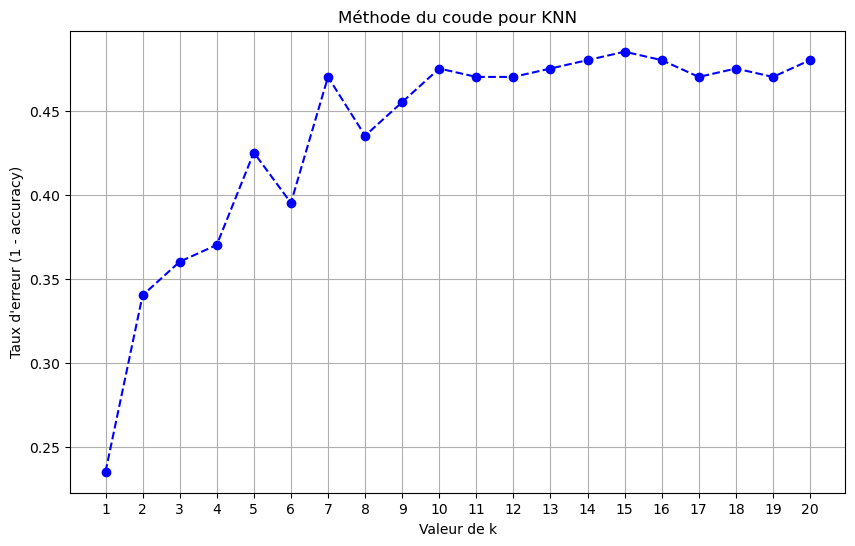

In [22]:
import matplotlib.pyplot as plt

error_rates = []
k_range = range(1, 21)  # On teste k de 1 à 20

for k in k_range:
    knn = Pipeline([
        ('preprocessing', preprocessor),
        ('classifier', KNeighborsClassifier(n_neighbors=k))
    ])
    knn.fit(X_train, y_train)
    y_pred_k = knn.predict(X_test)
    error = 1 - accuracy_score(y_test, y_pred_k)
    error_rates.append(error)

# 📈 Affichage de la courbe
plt.figure(figsize=(10,6))
plt.plot(k_range, error_rates, marker='o', linestyle='--', color='blue')
plt.title('Méthode du coude pour KNN')
plt.xlabel('Valeur de k')
plt.ylabel('Taux d\'erreur (1 - accuracy)')
plt.xticks(k_range)
plt.grid(True)
plt.show()


In [16]:
import pandas as pd
import pyodbc
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Connexion à la base SQL Server
conn = pyodbc.connect(
    'DRIVER={SQL Server};SERVER=KARIM;DATABASE=DW;Trusted_Connection=yes;'
)

# 📥 Requête pour charger les données nécessaires
query = """
SELECT 
    fs.Product_PK,
    dp.ProductName,
    dc.Category,
    fs.Prix_Unitaire_TND_1
FROM Fact_Sales fs
JOIN Dim_Product dp ON fs.Product_PK = dp.Product_PK
JOIN Dim_Category dc ON dp.Category_FK = dc.Category_PK
WHERE fs.Prix_Unitaire_TND_1 IS NOT NULL
"""

# Charger les données
df = pd.read_sql(query, conn)
conn.close()

# 🧠 Calcul de la moyenne par catégorie
df['Prix_Moyen_Categorie'] = df.groupby('Category')['Prix_Unitaire_TND_1'].transform('mean')

# 🎯 Ciblage : créer la variable binaire "Cher" (1 si prix > moyenne, sinon 0)
df['Cher'] = (df['Prix_Unitaire_TND_1'] > df['Prix_Moyen_Categorie']).astype(int)

# 🔍 Préparation des variables
X = df[['ProductName', 'Category']]
y = df['Cher']

# 🧼 Prétraitement
preprocessor = ColumnTransformer(transformers=[
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), ['ProductName', 'Category'])
])

# 📊 Séparer en train / test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🧪 Modèles
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier()
}

# 🔄 Entraînement et évaluation
for name, model in models.items():
    pipe = Pipeline([
        ('preprocessing', preprocessor),
        ('classifier', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    print(f"\n🔹 {name}")
    print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
    print(classification_report(y_test, y_pred))


C:\Users\karim\AppData\Local\Temp\ipykernel_14408\2897995721.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)



🔹 Logistic Regression
Accuracy: 0.63
              precision    recall  f1-score   support

           0       0.69      0.57      0.63       108
           1       0.58      0.70      0.63        92

    accuracy                           0.63       200
   macro avg       0.64      0.63      0.63       200
weighted avg       0.64      0.63      0.63       200


🔹 Random Forest
Accuracy: 0.655
              precision    recall  f1-score   support

           0       1.00      0.36      0.53       108
           1       0.57      1.00      0.73        92

    accuracy                           0.66       200
   macro avg       0.79      0.68      0.63       200
weighted avg       0.80      0.66      0.62       200


🔹 KNN
Accuracy: 0.585
              precision    recall  f1-score   support

           0       0.69      0.42      0.52       108
           1       0.53      0.78      0.63        92

    accuracy                           0.58       200
   macro avg       0.61      0.60 

In [28]:
import pandas as pd
import pyodbc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score

# 🔌 Connexion à la base SQL Server
conn = pyodbc.connect('DRIVER={SQL Server};SERVER=KARIM;DATABASE=DW;Trusted_Connection=yes;')

# 📥 Requêtes SQL
query_category = "SELECT Category_PK, Category FROM [DW].[dbo].[Dim_Category]"
query_product = "SELECT Product_PK, ProductName, Category_FK FROM [DW].[dbo].[Dim_Product]"
query_sales = """
SELECT TOP (10000) Product_PK, Prix_Unitaire_TND_1
FROM [DW].[dbo].[Fact_Sales]
WHERE Prix_Unitaire_TND_1 IS NOT NULL
"""

# 📊 Chargement des données
df_cat = pd.read_sql(query_category, conn)
df_prod = pd.read_sql(query_product, conn)
df_sales = pd.read_sql(query_sales, conn)
conn.close()

# 🔗 Fusion des données
df = df_sales.merge(df_prod, on='Product_PK')
df = df.merge(df_cat, left_on='Category_FK', right_on='Category_PK')

# 🧠 Création de la variable cible : Cher (1) ou Non Cher (0)
df['Moyenne_Categorie'] = df.groupby('Category')['Prix_Unitaire_TND_1'].transform('mean')
df['Cher'] = (df['Prix_Unitaire_TND_1'] > df['Moyenne_Categorie']).astype(int)

# 🎯 Séparation features / target
X = df[['ProductName', 'Category']]
y = df['Cher']

# 📦 Prétraitement
categorical_features = ['ProductName', 'Category']
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('cat', categorical_transformer, categorical_features)
], remainder='passthrough')

# ⚙️ Modèles avec meilleurs paramètres initiaux
models = {
    'Logistic Regression': LogisticRegression(C=1.0, solver='liblinear', max_iter=500),
    'Random Forest': RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_split=4, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5, weights='distance', metric='euclidean')
}

# 📊 Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🧪 Entraînement et évaluation
for name, model in models.items():
    pipe = Pipeline([
        ('preprocessing', preprocessor),
        ('scaler', StandardScaler(with_mean=False)),  # Important avec OneHotEncoder
        ('classifier', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    print(f"\n🔹 {name}")
    print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
    print("F1-score:", round(f1_score(y_test, y_pred), 3))
    print(classification_report(y_test, y_pred))


C:\Users\karim\AppData\Local\Temp\ipykernel_14408\2784839535.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_cat = pd.read_sql(query_category, conn)
C:\Users\karim\AppData\Local\Temp\ipykernel_14408\2784839535.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_prod = pd.read_sql(query_product, conn)
C:\Users\karim\AppData\Local\Temp\ipykernel_14408\2784839535.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sales = pd.read_sql(query_sales, conn)



🔹 Logistic Regression
Accuracy: 0.745
F1-score: 0.741
              precision    recall  f1-score   support

           0       0.75      0.75      0.75       101
           1       0.74      0.74      0.74        99

    accuracy                           0.74       200
   macro avg       0.74      0.74      0.74       200
weighted avg       0.74      0.74      0.74       200


🔹 Random Forest
Accuracy: 0.69
F1-score: 0.69
              precision    recall  f1-score   support

           0       0.70      0.68      0.69       101
           1       0.68      0.70      0.69        99

    accuracy                           0.69       200
   macro avg       0.69      0.69      0.69       200
weighted avg       0.69      0.69      0.69       200


🔹 KNN
Accuracy: 0.77
F1-score: 0.697
              precision    recall  f1-score   support

           0       0.69      1.00      0.81       101
           1       1.00      0.54      0.70        99

    accuracy                           0.7